In [3]:
# Load relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm

In [4]:
!pip install openpyxl


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


QUESTION 1: 
Assume that we are standing at time t = 0 with initial values, x_0, as specified in init values.xlsx.
What is the distribution of X1? Simulate the evolution of Xt with weekly time steps from
time zero to the horizon. Visualize the evolution of log FX_t.

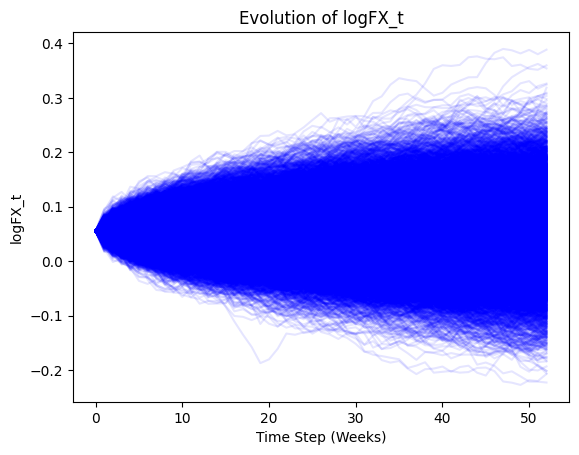

In [5]:
# Load data
covariance_matrix = pd.read_excel('covariance_matrix.xlsx', index_col=0)
init_values = pd.read_excel('init_values.xlsx', index_col=0)

# Parameters
mu = np.array([0, 0.07/52, 0.06/52] + [0] * (len(covariance_matrix) - 3))
sigma = covariance_matrix.values
initial_values = init_values.values.flatten()

# Simulation parameters
time_steps = 52  # Weekly time steps for one year
num_simulations = 10000 # Number of simulation paths
n_assets = len(initial_values)

# Simulate paths
paths = np.zeros((num_simulations, time_steps + 1, n_assets))
paths[:, 0, :] = initial_values

for t in range(1, time_steps + 1):
    delta_x = np.random.multivariate_normal(mu, sigma, size=num_simulations)
    paths[:, t, :] = paths[:, t-1, :] + delta_x

# Extract logFX_t and visualize
log_fx_t = paths[:, :, 0]  # Assuming logFX_t is the first variable
plt.plot(range(time_steps + 1), log_fx_t.T, alpha=0.1, color='blue')
plt.title("Evolution of logFX_t")
plt.xlabel("Time Step (Weeks)")
plt.ylabel("logFX_t")
plt.show()

QUESTION 2: 


Obtain the distribution of V US,local
1 . Again, simulate the the evolution of V US,local
1 . Compare the simulated data with the true analytical distribution.

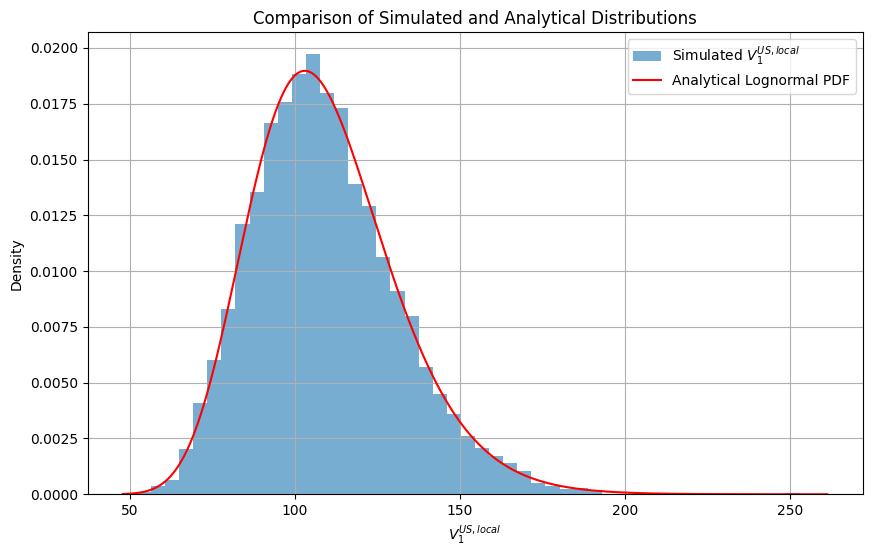

In [6]:
# Parameters
V_0 = 100  # Initial value of V^{US,local}
delta_t = 1 / 52  # Weekly time step
T = 1  # Time horizon (1 year)
n_steps = int(T / delta_t)  # Number of time steps
n_simulations = 10000  # Number of simulation paths

# Mean and variance for log V^{US,local}
mu_V = 0.07  # Annual growth rate for US equities
sigma_V2 = 0.04  # Variance of log V^{US,local}

# Analytical distribution parameters
mu_log_V = np.log(V_0) + mu_V * T
sigma_log_V = np.sqrt(sigma_V2 * T)

# Simulate evolution
np.random.seed(42)  # For reproducibility
log_V_t = np.full((n_simulations, 1), np.log(V_0))  # Initialize log V_0

# Simulate weekly steps
for _ in range(n_steps):
    delta_log_V = np.random.normal(mu_V * delta_t, np.sqrt(sigma_V2 * delta_t), size=(n_simulations, 1))
    log_V_t = np.hstack((log_V_t, log_V_t[:, -1:] + delta_log_V))

# Extract final values
V_1_simulated = np.exp(log_V_t[:, -1])

# Analytical PDF for comparison
x = np.linspace(min(V_1_simulated), max(V_1_simulated), 1000)
pdf = lognorm.pdf(x, s=sigma_log_V, scale=np.exp(mu_log_V))

# Plot histogram and analytical PDF
plt.figure(figsize=(10, 6))
plt.hist(V_1_simulated, bins=50, density=True, alpha=0.6, label='Simulated $V_1^{US,local}$')
plt.plot(x, pdf, label='Analytical Lognormal PDF', color='red')
plt.xlabel('$V_1^{US,local}$')
plt.ylabel('Density')
plt.title('Comparison of Simulated and Analytical Distributions')
plt.legend()
plt.grid()
plt.show()


In [10]:
init_values = pd.read_excel("init_values.xlsx", index_col=0)
X0_vals = init_values["initial values"].values
var_names = init_values.index.values

X0 = X0_vals.copy().astype(float)
X0[0] = np.log(X0[0])  # log(FX)

covariance_matrix = pd.read_excel("covariance_matrix.xlsx", index_col=0)
Sigma = covariance_matrix.values

dt = 1/52
T = 52  # number of weeks in a year
mu = np.zeros(len(X0))
mu[1] = 0.07 * dt
mu[2] = 0.06 * dt

idx_5y_eur = np.where(var_names == "5Y EUR")[0][0]



In [11]:
y0_5y_eur = X0[idx_5y_eur]
mu_y = mu[idx_5y_eur]  # should be 0 for yields
sigma_y = np.sqrt(Sigma[idx_5y_eur, idx_5y_eur])
m = y0_5y_eur + T * mu_y
s = np.sqrt(T) * sigma_y

In [12]:
N_sims_bond = 10000
final_yields = np.zeros(N_sims_bond)
for i in range(N_sims_bond):
    # simulate T increments for the yield only
    dX_path = np.random.multivariate_normal(mu, Sigma, size=T)
    final_yields[i] = y0_5y_eur + np.sum(dX_path[:, idx_5y_eur])

final_bond_prices = np.exp(-5 * final_yields)

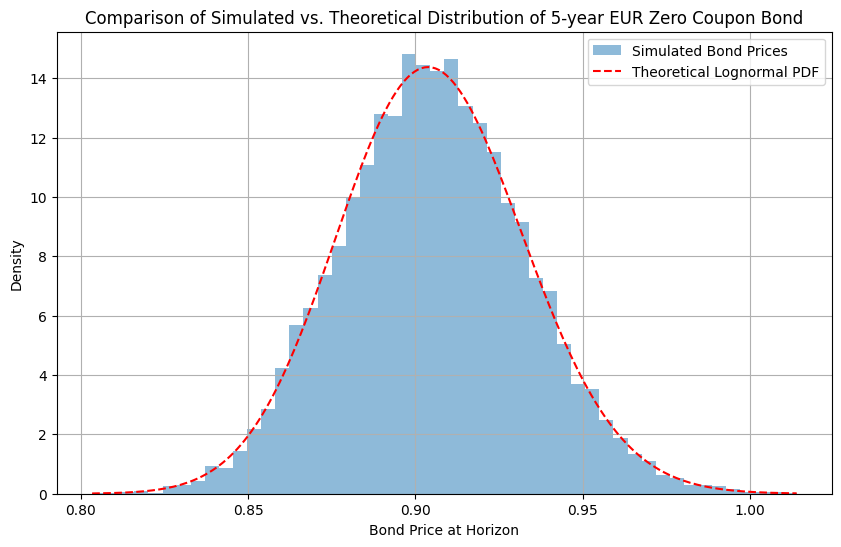

In [13]:
# Compare simulated distribution to theoretical lognormal
mu_P = -5 * m
sigma_P = 5 * s

plt.figure(figsize=(10,6))
counts, bins, _ = plt.hist(final_bond_prices, bins=50, density=True, alpha=0.5, label='Simulated Bond Prices')
x = np.linspace(min(final_bond_prices), max(final_bond_prices), 200)
theoretical_pdf = lognorm.pdf(x, s=sigma_P, scale=np.exp(mu_P))
plt.plot(x, theoretical_pdf, 'r--', label='Theoretical Lognormal PDF')

plt.xlabel('Bond Price at Horizon')
plt.ylabel('Density')
plt.title('Comparison of Simulated vs. Theoretical Distribution of 5-year EUR Zero Coupon Bond')
plt.legend()
plt.grid(True)
plt.show()